In [1]:
import os
import re
import time
import copy

from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models, datasets, transforms

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print(torch.cuda.is_available())

/home/user/mambaforge/envs/training/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
True


input dir

In [2]:
CURRENT_DIR = os.getcwd()
MAIN_FOLDER = Path(CURRENT_DIR).parent
OUTPUT_FOLDER = os.path.join(CURRENT_DIR, 'aligned')  
FOLD_DATA = os.path.join(CURRENT_DIR, 'fold_data') 

BATCH_SIZE = 32

DEVICE = torch.device("cuda")


Data processing

In [3]:
# Data Transforms
def get_data_transforms():
    normalize = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

    return {
        'train': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
        'val': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
        'test': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(*normalize)
        ]),
    }

data_transforms = get_data_transforms()

In [5]:
class BasicImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(self.labels[idx], dtype=torch.long)  

In [6]:
def load_folds_dataset(image_root, fold_dir, fold_files):
    image_paths = []
    labels = []

    for fold_file in fold_files:
        print(f"Reading fold file: {fold_file}")
        with open(os.path.join(fold_dir, fold_file), 'r') as f:
            next(f)  
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) < 5:
                    continue
                user_id = parts[0]
                original_img_name = parts[1]
                gender = parts[4].lower()

                if gender not in ["m", "f"]:
                    continue
                label = 0 if gender == "m" else 1

                user_folder = os.path.join(image_root, user_id)
                if not os.path.isdir(user_folder):
                    continue

                for file in os.listdir(user_folder):
                    if original_img_name in file:
                        full_path = os.path.join(user_folder, file)
                        if os.path.isfile(full_path):
                            image_paths.append(full_path)
                            labels.append(label)
                        break

    return image_paths, labels


In [7]:
def get_dataloaders(batch_size, train_folds, val_fold):
    train_image_paths, train_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, train_folds)
    val_image_paths, val_labels = load_folds_dataset(OUTPUT_FOLDER, FOLD_DATA, [val_fold])

    train_dataset = BasicImageDataset(train_image_paths, train_labels, transform=data_transforms['train'])
    val_dataset = BasicImageDataset(val_image_paths, val_labels, transform=data_transforms['val'])

    print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")

    if len(train_dataset) == 0 or len(val_dataset) == 0:
        return None

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return {'train': train_loader, 'val': val_loader}


model

In [ ]:
# class ResnetGender(nn.Module):
#     def __init__(self, layers=18, pretrained=True, drop_rate=0.3):
#         super().__init__()
        
#         if layers == 18:
#             base_model = torchvision.models.resnet18(pretrained=pretrained)
#             block_expansion = 1

#         self.resnet = nn.Sequential(*list(base_model.children())[:-1]) 
#         self.pool = nn.AdaptiveAvgPool2d((1, 1))  
        
#         self.extra_layer = nn.Sequential(
#             nn.Linear(block_expansion * 512, 256),
#             nn.BatchNorm1d(256),
#             nn.Dropout(drop_rate),
#             nn.ReLU(),
#         )
#         self.gender_predictor = nn.Sequential(
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),
#             nn.Dropout(drop_rate),
#             nn.ReLU(),
#             nn.Linear(128, 2)
#         )

#     def forward(self, x):
#         x = self.resnet(x)
#         x = self.pool(x)
#         x = x.view(x.size(0), -1)
#         x = self.extra_layer(x)
#         return self.gender_predictor(x)


In [4]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

Train

In [12]:
# intialize model resnet18
def load_model(drop_rate=0.3):
    base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    num_ftrs = base_model.fc.in_features
    base_model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(drop_rate),
        nn.ReLU(),
        nn.Linear(128, 2)  
    )
    return base_model.to(DEVICE)

# def load_model(drop_rate=0.3):
#     return ResnetGender(layers=18, pretrained=True, drop_rate=drop_rate).to(DEVICE)

In [13]:
def train_model(model, dataloaders, optimizer, num_epochs=50, patience=10):
    criterion = LabelSmoothingCrossEntropy()
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.25)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")
    epochs_no_improve = 0
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_prec': [], 'val_prec': [],
        'train_rec': [], 'val_rec': [],
        'train_f1': [], 'val_f1': [],
    }

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = torch.argmax(outputs, dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_prec = precision_score(all_labels, all_preds, zero_division=0)
            epoch_rec = recall_score(all_labels, all_preds, zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, zero_division=0)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)
            history[f'{phase}_prec'].append(epoch_prec)
            history[f'{phase}_rec'].append(epoch_rec)
            history[f'{phase}_f1'].append(epoch_f1)

            print(f"{phase.upper()} — Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"Prec: {epoch_prec:.4f} | Rec: {epoch_rec:.4f} | F1: {epoch_f1:.4f}")

            if phase == 'val':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
        if phase == 'train':
            scheduler.step()
            
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    def plot_training_curves(history):
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['val_acc'], label='Validation Accuracy')
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Validation Accuracy over Epochs")
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history['val_loss'], label='Validation Loss', color='orange')
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Validation Loss over Epochs")
        plt.legend()
        plt.tight_layout()
        plt.show()

    plot_training_curves(history)
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete — Best Val Loss: {best_loss:.4f}")
    return model, history


Fold 0: Val = fold_0_data.txt, Train = ['fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_0_data.txt
Train size: 13497, Val size: 3995

Epoch 1/50
TRAIN — Loss: 0.6586 | Acc: 0.6344 | Prec: 0.6550 | Rec: 0.7084 | F1: 0.6806
VAL — Loss: 0.6827 | Acc: 0.6058 | Prec: 0.5989 | Rec: 0.5796 | F1: 0.5891

Epoch 2/50
TRAIN — Loss: 0.6053 | Acc: 0.7074 | Prec: 0.7236 | Rec: 0.7573 | F1: 0.7401
VAL — Loss: 0.6107 | Acc: 0.7004 | Prec: 0.7031 | Rec: 0.6674 | F1: 0.6848

Epoch 3/50
TRAIN — Loss: 0.5719 | Acc: 0.7453 | Prec: 0.7553 | Rec: 0.7942 | F1: 0.7743
VAL — Loss: 0.6445 | Acc: 0.6703 | Prec: 0.6142 | Rec: 0.8711 | F1: 0.7204

Epoch 4/50
TRAIN — Loss: 0.5481 | Acc: 0.7715 | Prec: 0.7818 | Rec: 0.8109 | F1: 0.7961
VAL — Loss: 0.5888 | Acc: 0.7389 | Prec: 0.7851 | Rec: 0.6396 | F1: 0.7050

Epoch 5/50
TRAIN —

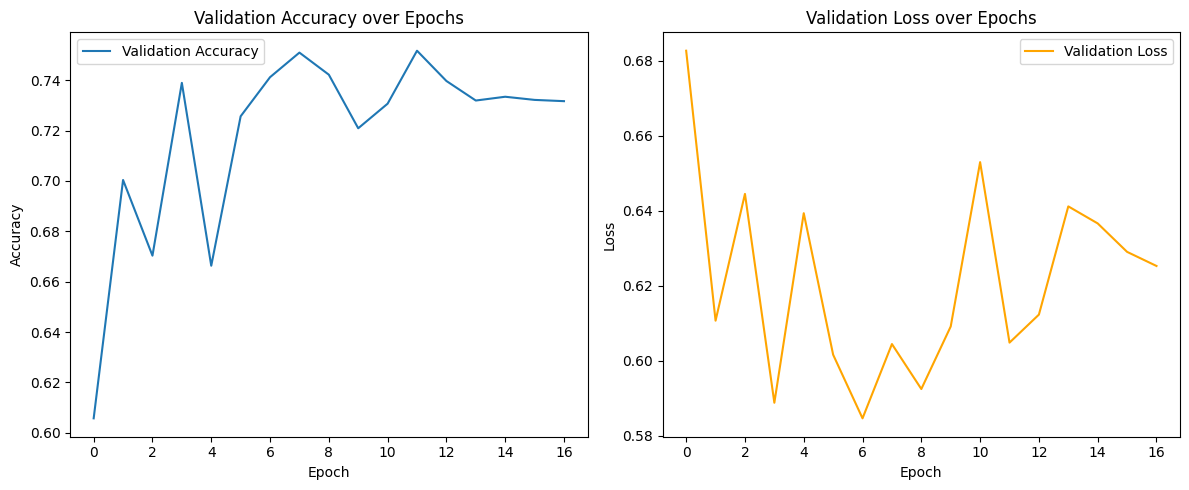


Training complete — Best Val Loss: 0.5847
Fold 1: Val = fold_1_data.txt, Train = ['fold_0_data.txt', 'fold_2_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_1_data.txt
Train size: 13883, Val size: 3609

Epoch 1/50
TRAIN — Loss: 0.6365 | Acc: 0.6637 | Prec: 0.6751 | Rec: 0.7071 | F1: 0.6907
VAL — Loss: 0.6682 | Acc: 0.6290 | Prec: 0.6989 | Rec: 0.5796 | F1: 0.6337

Epoch 2/50
TRAIN — Loss: 0.5807 | Acc: 0.7372 | Prec: 0.7389 | Rec: 0.7811 | F1: 0.7594
VAL — Loss: 0.6021 | Acc: 0.7104 | Prec: 0.6983 | Rec: 0.8398 | F1: 0.7626

Epoch 3/50
TRAIN — Loss: 0.5596 | Acc: 0.7585 | Prec: 0.7637 | Rec: 0.7897 | F1: 0.7765
VAL — Loss: 0.6308 | Acc: 0.6872 | Prec: 0.7451 | Rec: 0.6612 | F1: 0.7006

Epoch 4/50
TRAIN — Loss: 0.5424 | Acc: 0.7761 | Prec: 0.7779 | Rec: 0.8096 | F1: 0.7934
VAL — Loss: 0.6004 | Acc: 0.7066 | Prec: 0.6856 | R

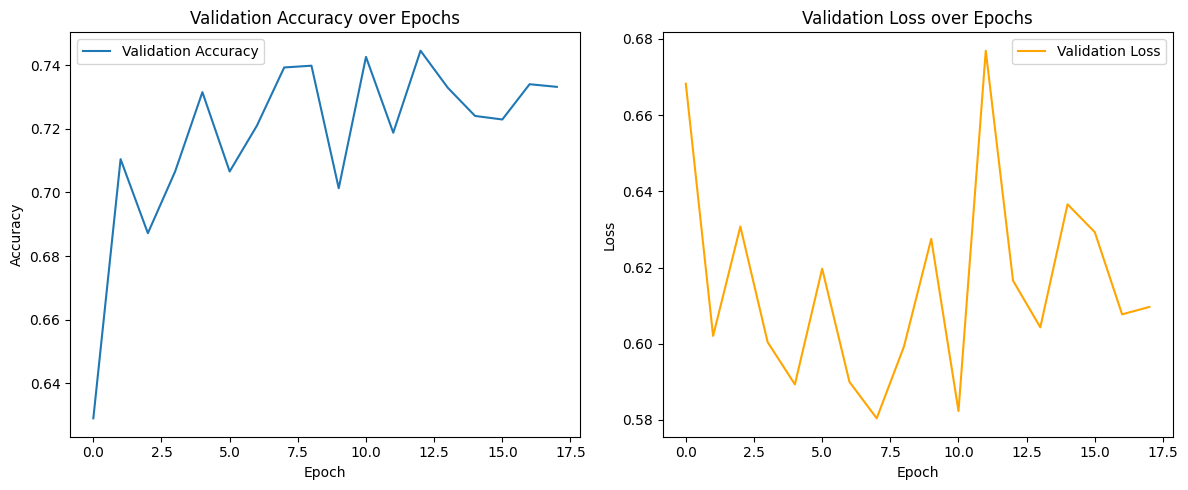


Training complete — Best Val Loss: 0.5804
Fold 2: Val = fold_2_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_3_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_2_data.txt
Train size: 14355, Val size: 3137

Epoch 1/50
TRAIN — Loss: 0.6311 | Acc: 0.6726 | Prec: 0.6832 | Rec: 0.7111 | F1: 0.6969
VAL — Loss: 0.6435 | Acc: 0.6764 | Prec: 0.7037 | Rec: 0.7390 | F1: 0.7209

Epoch 2/50
TRAIN — Loss: 0.5848 | Acc: 0.7363 | Prec: 0.7458 | Rec: 0.7614 | F1: 0.7535
VAL — Loss: 0.5689 | Acc: 0.7587 | Prec: 0.7712 | Rec: 0.8151 | F1: 0.7925

Epoch 3/50
TRAIN — Loss: 0.5647 | Acc: 0.7542 | Prec: 0.7595 | Rec: 0.7839 | F1: 0.7715
VAL — Loss: 0.5786 | Acc: 0.7472 | Prec: 0.7957 | Rec: 0.7441 | F1: 0.7690

Epoch 4/50
TRAIN — Loss: 0.5482 | Acc: 0.7737 | Prec: 0.7800 | Rec: 0.7972 | F1: 0.7885
VAL — Loss: 0.6132 | Acc: 0.6908 | Prec: 0.8333 | R

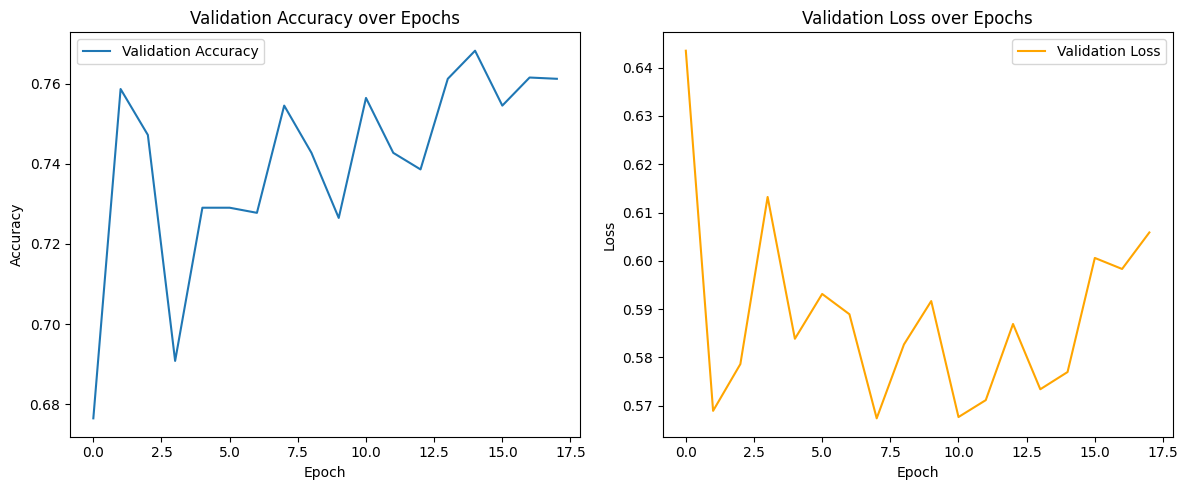


Training complete — Best Val Loss: 0.5674
Fold 3: Val = fold_3_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_4_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_4_data.txt
Reading fold file: fold_3_data.txt
Train size: 14186, Val size: 3306

Epoch 1/50
TRAIN — Loss: 0.6423 | Acc: 0.6558 | Prec: 0.6726 | Rec: 0.6912 | F1: 0.6818
VAL — Loss: 0.6433 | Acc: 0.6506 | Prec: 0.6440 | Rec: 0.8043 | F1: 0.7153

Epoch 2/50
TRAIN — Loss: 0.5836 | Acc: 0.7293 | Prec: 0.7387 | Rec: 0.7622 | F1: 0.7503
VAL — Loss: 0.5688 | Acc: 0.7529 | Prec: 0.7519 | Rec: 0.8165 | F1: 0.7829

Epoch 3/50
TRAIN — Loss: 0.5563 | Acc: 0.7648 | Prec: 0.7724 | Rec: 0.7927 | F1: 0.7824
VAL — Loss: 0.5725 | Acc: 0.7477 | Prec: 0.7497 | Rec: 0.8071 | F1: 0.7774

Epoch 4/50
TRAIN — Loss: 0.5421 | Acc: 0.7772 | Prec: 0.7834 | Rec: 0.8050 | F1: 0.7941
VAL — Loss: 0.5704 | Acc: 0.7514 | Prec: 0.7440 | R

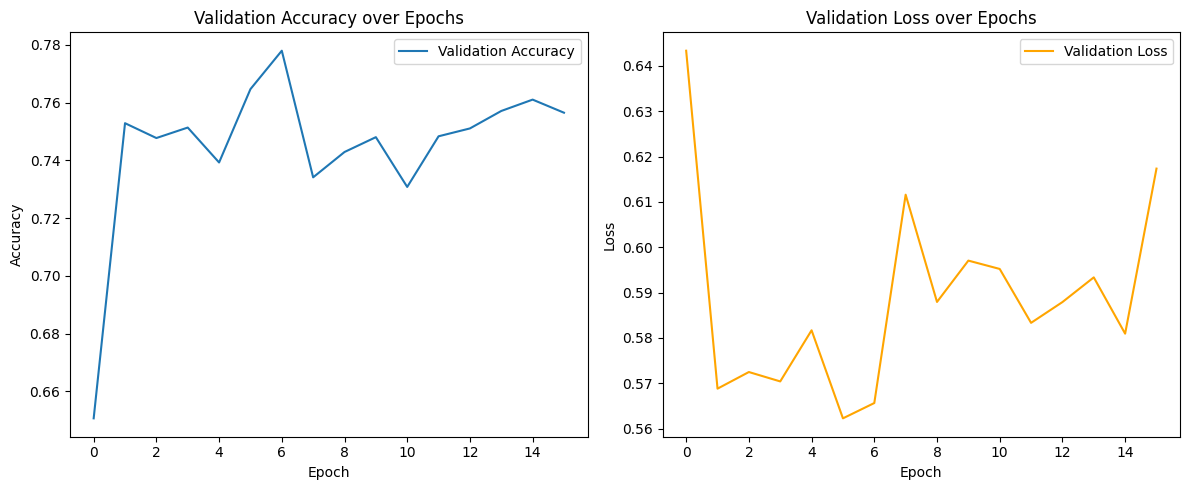


Training complete — Best Val Loss: 0.5623
Fold 4: Val = fold_4_data.txt, Train = ['fold_0_data.txt', 'fold_1_data.txt', 'fold_2_data.txt', 'fold_3_data.txt']
Reading fold file: fold_0_data.txt
Reading fold file: fold_1_data.txt
Reading fold file: fold_2_data.txt
Reading fold file: fold_3_data.txt
Reading fold file: fold_4_data.txt
Train size: 14047, Val size: 3445

Epoch 1/50
TRAIN — Loss: 0.6178 | Acc: 0.6886 | Prec: 0.7003 | Rec: 0.7318 | F1: 0.7157
VAL — Loss: 0.6597 | Acc: 0.6261 | Prec: 0.6532 | Rec: 0.6461 | F1: 0.6496

Epoch 2/50
TRAIN — Loss: 0.5608 | Acc: 0.7578 | Prec: 0.7645 | Rec: 0.7917 | F1: 0.7779
VAL — Loss: 0.6509 | Acc: 0.6470 | Prec: 0.7277 | Rec: 0.5465 | F1: 0.6242

Epoch 3/50
TRAIN — Loss: 0.5408 | Acc: 0.7801 | Prec: 0.7840 | Rec: 0.8135 | F1: 0.7985
VAL — Loss: 0.6448 | Acc: 0.6891 | Prec: 0.7027 | Rec: 0.7289 | F1: 0.7155

Epoch 4/50
TRAIN — Loss: 0.5279 | Acc: 0.7925 | Prec: 0.7935 | Rec: 0.8280 | F1: 0.8104
VAL — Loss: 0.6612 | Acc: 0.6848 | Prec: 0.7332 | R

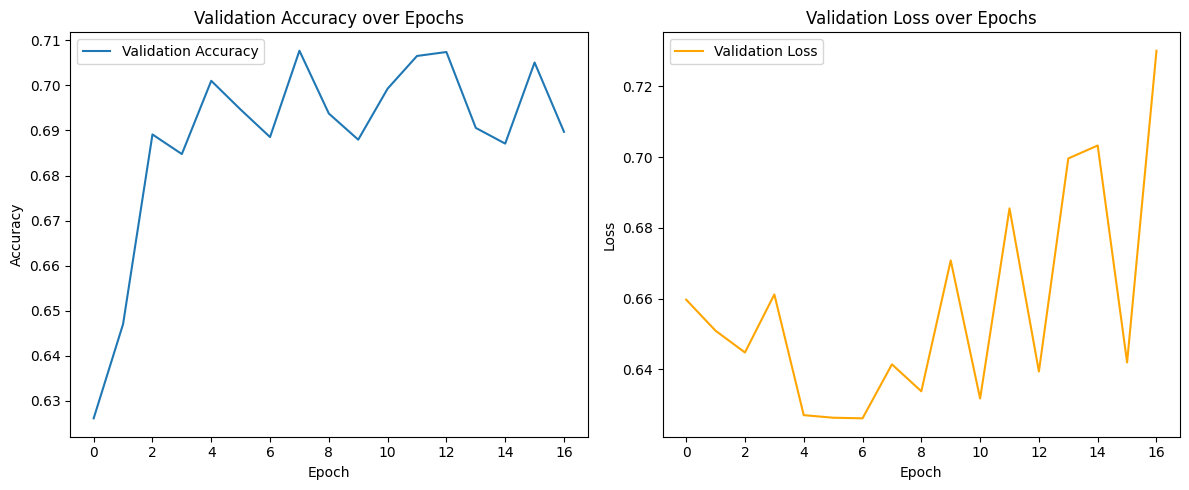


Training complete — Best Val Loss: 0.6261


In [10]:
all_folds = [f"fold_{i}_data.txt" for i in range(5)]
for fold_idx in range(5):
    val_fold = all_folds[fold_idx]
    train_folds = [f for i, f in enumerate(all_folds) if i != fold_idx]
    print(f"Fold {fold_idx}: Val = {val_fold}, Train = {train_folds}")

    dataloaders = get_dataloaders(batch_size=32, train_folds=train_folds, val_fold=val_fold)

    model = load_model(drop_rate=0.3)
    params_to_update = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params_to_update, lr=0.001)

    model, history = train_model(model, dataloaders, optimizer, num_epochs=50)
    best_val_acc = max(history['val_acc'])

In [14]:
# Save the model
torch.save(model, 'resnet_test.pth')
print("Model saved as efficientnet_test.pth")

Model saved as efficientnet_test.pth
